In [1]:
import sys

sys.path.append('../utils')

In [2]:
# Import packages
from caveclient import CAVEclient
#import skeleton_plot as skelplot

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csr_array
from typing import Union, Optional
from utils import check_index, adjacencyplot
from os.path import join as pjoin
import itertools
import scipy.spatial as spatial

In [3]:
## UTILS


def filter_synapse_table(synapse_table: pd.DataFrame,
                         pre_root_ids=None,
                         post_root_ids=None):
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """

    if pre_root_ids is not None:
        assert isinstance(
            pre_root_ids, (np.ndarray, list, pd.core.series.Series)
        ), (f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
           )
        pre_mask = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_mask = np.ones(len(synapse_table), dtype=bool)

    if post_root_ids is not None:
        assert isinstance(
            post_root_ids, (np.ndarray, list, pd.core.series.Series)
        ), (f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
           )
        post_mask = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_mask = np.ones(len(synapse_table), dtype=bool)

    return synapse_table[pre_mask & post_mask]


def make_adjacency(
    synapses,
    source_cell_index: Union[pd.Index, pd.DataFrame, pd.Series, np.ndarray,
                             list],
    target_cell_index: Optional[Union[pd.Index, pd.DataFrame, pd.Series,
                                      np.ndarray, list]] = None,
    aggfunc="binary",
    return_as="dense",
) -> Union[csr_array, np.ndarray]:
    source_cell_index = check_index(source_cell_index)
    if target_cell_index is None:
        target_cell_index = source_cell_index
    else:
        target_cell_index = check_index(target_cell_index)
    synapses = synapses.query(
        "pre_pt_root_id in @source_cell_index and post_pt_root_id in @target_cell_index"
    )
    groupby = synapses.groupby(["pre_pt_root_id", "post_pt_root_id"])
    if aggfunc == "count":
        edges = groupby.size().rename("weight").reset_index()
    elif aggfunc == "binary":
        edges = groupby.size().transform(lambda x: x > 0).rename(
            "weight").reset_index()
    else:
        edges = groupby["size"].agg(aggfunc).rename("weight").reset_index()
    # make sure that the adjacency matrix is sorted the same as the input cell index
    edges["source_index"] = source_cell_index.get_indexer(
        edges["pre_pt_root_id"])
    edges["target_index"] = target_cell_index.get_indexer(
        edges["post_pt_root_id"])
    adjacency = csr_array(
        (edges["weight"], (edges["source_index"], edges["target_index"])),
        shape=(len(source_cell_index), len(target_cell_index)),
        dtype=edges["weight"].dtype,
    )
    # NOTE: for many applications working with sparse matrices is more efficient
    # but for ease of use and visualization in this workshop we return a dense matrix
    if return_as == "dense":
        adjacency = adjacency.todense()
    elif return_as == "sparse":
        pass  # already in sparse format
    else:
        raise ValueError(f"Unknown return_as type: {return_as}")
    return adjacency


from typing import Union, List


def calculate_neuronal_distance(
        pre_cell_df: pd.DataFrame,
        post_cell_df: pd.DataFrame,
        distance_type: Union[str, List[str]] = "3d") -> pd.DataFrame:
    """
    Calculate pairwise distances between pre- and post-synaptic cells.
    
    Parameters
    ----------
    pre_cell_df : pd.DataFrame
        DataFrame containing presynaptic cell information with position columns
    post_cell_df : pd.DataFrame
        DataFrame containing postsynaptic cell information with position columns
    distance_type : str or list of str, default "3d"
        Type(s) of distance to calculate. Options: "lateral", "vertical", "3d"
        
    Returns
    -------
    pd.DataFrame
        DataFrame with columns for cell ID pairs and calculated distances
    """
    # Normalize distance_type to list
    if isinstance(distance_type, str):
        distance_type = [distance_type]

    # Define column mappings for different distance types
    distance_column_map = {
        "lateral": [
            "pt_position_trform_x",
            "pt_position_trform_z",
        ],
        "vertical": ["pt_position_trform_y"],
        "3d": [
            "pt_position_trform_x",
            "pt_position_trform_y",
            "pt_position_trform_z",
        ]
    }

    # Validate distance types
    invalid_types = set(distance_type) - set(distance_column_map.keys())
    if invalid_types:
        raise ValueError(f"Unknown distance type(s): {invalid_types}. "
                         f"Valid options: {list(distance_column_map.keys())}")

    # Calculate distances for each type
    distances = {}
    for dist_type in distance_type:
        dist_columns = distance_column_map[dist_type]

        pre_positions = pre_cell_df[dist_columns].values
        post_positions = post_cell_df[dist_columns].values

        pairwise_distances = spatial.distance.cdist(pre_positions,
                                                    post_positions)
        distances[dist_type] = pairwise_distances.flatten()

    id_pairs = list(
        itertools.product(pre_cell_df["pt_root_id"],
                          post_cell_df["pt_root_id"]))
    result_df = pd.DataFrame(id_pairs,
                             columns=['pre_pt_root_id', 'post_pt_root_id'])

    # Add distance columns
    for dist_type, dist_values in distances.items():
        result_df[f'distance_{dist_type}'] = dist_values

    # Remove self-connections (where pre and post IDs are the same)
    result_df = result_df[result_df['pre_pt_root_id'] !=
                          result_df['post_pt_root_id']]

    return result_df


In [4]:
data_dir = '/Users/rodrigo.gonzalezlaiz/Desktop/v1dd_1196'
mat_version = '1196'

In [5]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(
    pjoin(data_dir, f"proofread_dendrite_list_{mat_version}.npy"))
axon_proof_root_ids = np.load(
    pjoin(data_dir, f"proofread_axon_list_{mat_version}.npy"))

print(
    f"There are {len(dendrite_proof_root_ids)} cells with acceptable dendrites, and {len(axon_proof_root_ids)} cells with axon proofreading"
)
print(
    f"The number of cells with usable axons and dendrites is: {(np.isin(axon_proof_root_ids, dendrite_proof_root_ids).sum())}"
)

There are 63986 cells with acceptable dendrites, and 1210 cells with axon proofreading
The number of cells with usable axons and dendrites is: 1148


In [6]:
syn_df = pd.read_feather(
    f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")

print(syn_df.shape)

(8204497, 13)


In [ ]:
# get the ids of all proofread cells with both axon and dendrite proofreading
proof_root_ids = axon_proof_root_ids[np.isin(axon_proof_root_ids,
                                             dendrite_proof_root_ids)]

#NOTE(Rodrigo): proof_root_ids contains both "presynaptic" and "postsynaptic" root ids.
# only use synapses with proofread cells

syn_df = pd.read_feather(
    f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")

print(syn_df.shape)
proofread_syn_df = filter_synapse_table(syn_df, proof_root_ids,
                                        proof_root_ids).reset_index(drop=True)


In [8]:
cell_df = pd.read_feather(
    f"{data_dir}/soma_and_cell_type_{mat_version}.feather")
cell_df['depth_um'] = cell_df['pt_position_trform_y'] / 1_000  # from nm to um
cell_df[[col for col in cell_df.columns if "position" in col]] /= 1000.

In [ ]:
# note (rodrigo): in the workshop they only use the axon proofread cells (1164 cells)
cell_df_proofread = cell_df[
    np.isin(cell_df['pt_root_id'], axon_proof_root_ids) &
    np.isin(cell_df['pt_root_id'], dendrite_proof_root_ids)].reset_index(
        drop=True)
cell_df_proofread_l3 = cell_df_proofread[cell_df_proofread["cell_type"] ==
                                         "L3-IT"]

In [23]:
cell_df

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume,cell_type_coarse,cell_type,depth_um
0,228132,632.828,749.849,738.270,-323.721448,549.910283,392.909833,864691132737039043,458.464831,None,None,549.910283
1,543247,1304.922,977.915,83.880,330.339020,595.962276,-306.424551,864691132730839988,73.345940,None,None,595.962276
2,203262,624.680,531.094,283.770,-252.082628,203.770728,21.544030,864691132654552792,338.276613,E,L3-IT,203.770728
3,350562,894.573,478.559,163.530,20.989259,117.514626,-98.554035,864691132773514104,326.965400,E,L2-IT,117.514626
4,718122,1729.859,674.111,781.200,803.635727,475.075415,467.669881,864691132774106773,333.888647,None,None,475.075415
...,...,...,...,...,...,...,...,...,...,...,...,...
207450,527607,1262.940,628.094,734.445,352.037267,418.290963,436.647625,864691132639606383,100.547645,None,None,418.290963
207451,168582,491.518,1057.067,92.070,-521.847320,688.587871,-335.347345,864691133042980384,369.919126,None,None,688.587871
207452,29422,302.330,415.005,81.855,-570.524838,35.550649,-177.610742,0,285.031368,None,None,35.550649
207453,422767,1065.603,538.932,36.405,191.665102,141.490682,-231.412518,864691132851361283,394.724290,None,None,141.490682


In [32]:
def create_pairs_df(df):

    # Do a cartesian product (self-merge on nothing)
    df_pre = df.add_prefix("pre_")
    df_post = df.add_prefix("post_")
    df_pairs = df_pre.merge(df_post, how="cross")

    # Remove self-pairs
    df_pairs = df_pairs[df_pairs["pre_id"] != df_pairs["post_id"]].reset_index(
        drop=True)

    return df_pairs


cell_df_proofread_pairs = create_pairs_df(cell_df_proofread)

In [35]:
def add_distance_columns(df, distance_type="3d"):
    """
    Add distance columns to a DataFrame containing cell pairs.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cell pairs with pre_ and post_ position columns
    distance_type : str or list of str, default "3d"
        Type(s) of distance to calculate. Options: "lateral", "vertical", "3d"
        
    Returns
    -------
    pd.DataFrame
        DataFrame with added distance columns
    """
    # Normalize distance_type to list
    if isinstance(distance_type, str):
        distance_type = [distance_type]

    # Define column mappings for different distance types
    distance_column_map = {
        "lateral": [
            "pt_position_trform_x",
            "pt_position_trform_z",
        ],
        "vertical": ["pt_position_trform_y"],
        "3d": [
            "pt_position_trform_x",
            "pt_position_trform_y",
            "pt_position_trform_z",
        ]
    }

    # Validate distance types
    invalid_types = set(distance_type) - set(distance_column_map.keys())
    if invalid_types:
        raise ValueError(f"Unknown distance type(s): {invalid_types}. "
                         f"Valid options: {list(distance_column_map.keys())}")

    # Make a copy to avoid modifying the original DataFrame
    result_df = df.copy()

    # Calculate distances for each type
    for dist_type in distance_type:
        dist_columns = distance_column_map[dist_type]

        # Get pre and post position columns
        pre_columns = [f"pre_{col}" for col in dist_columns]
        post_columns = [f"post_{col}" for col in dist_columns]

        # Calculate distance row by row
        pre_positions = result_df[pre_columns].values
        post_positions = result_df[post_columns].values

        # Calculate Euclidean distance for each row
        distances = np.sqrt(np.sum((pre_positions - post_positions)**2, axis=1))

        # Add distance column
        result_df[f'distance_{dist_type}'] = distances

    return result_df


In [38]:
cell_pairs_with_distance = add_distance_columns(
    cell_df_proofread_pairs, distance_type=["3d", 'vertical'])

In [39]:
cell_pairs_with_distance

,pre_id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,pre_pt_position_trform_x,pre_pt_position_trform_y,pre_pt_position_trform_z,pre_pt_root_id,pre_volume,pre_cell_type_coarse,...,post_pt_position_trform_x,post_pt_position_trform_y,post_pt_position_trform_z,post_pt_root_id,post_volume,post_cell_type_coarse,post_cell_type,post_depth_um,distance_3d,distance_vertical
0,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,-67.856489,415.829186,13.006444,864691132710501931,453.768761,E,L5-IT,415.829186,102.165956,61.165998
1,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,-145.995980,274.794268,19.379727,864691132923215329,336.579200,I,DTC,274.794268,167.007057,79.868920
2,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,-37.633020,355.616431,-57.338047,864691132616354625,260.410740,I,ITC,355.616431,20.803410,0.953243
3,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,-69.027466,503.380292,-79.655916,864691132999200949,352.843100,E,L5-IT,503.380292,159.819007,148.717104
4,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,17.492220,397.154153,-139.157779,864691132657293527,305.316600,I,DTC,397.154153,103.459892,42.490965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316751,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,67.043560,325.154772,98.687317,864691132849454803,420.918766,I,PTC,325.154772,175.263901,112.289743
1316752,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,257.331255,218.305414,-78.400099,864691132819642111,159.295394,I,ITC,218.305414,291.439222,5.440384
1316753,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,17.544598,553.562858,34.298148,864691132679146333,325.794498,E,L6-IT,553.562858,344.959046,340.697828
1316754,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,3.578300,473.261098,-13.876769,864691132663975748,457.329970,E,L5-IT,473.261098,262.129587,260.396068


In [11]:
syn_df.shape, cell_df.shape, cell_df_proofread.shape, cell_df_proofread_l3.shape

((8204497, 13), (207455, 12), (1148, 12), (185, 12))

In [ ]:
# distance_df = calculate_neuronal_distance(pre_cell_df=cell_df_proofread,
#                                           post_cell_df=cell_df_proofread,
#                                           distance_type=["3d", 'vertical'])
# distance_df.head(5)

,pre_pt_root_id,post_pt_root_id,distance_3d,distance_vertical
1,864691132625300120,864691132710501931,102.165956,61.165998
2,864691132625300120,864691132923215329,167.007057,79.868920
3,864691132625300120,864691132616354625,20.803410,0.953243
4,864691132625300120,864691132999200949,159.819007,148.717104
5,864691132625300120,864691132657293527,103.459892,42.490965


In [81]:
# # merge distance with cell type information
# distance_df = pd.merge(distance_df,
#                        cell_df_proofread[[
#                            'pt_root_id',
#                            'cell_type_coarse',
#                            'cell_type',
#                        ]],
#                        left_on='pre_pt_root_id',
#                        right_on='pt_root_id',
#                        how='left')
# distance_df = distance_df.rename(columns={
#     'cell_type_coarse': 'pre_cell_type_coarse',
#     'cell_type': 'pre_cell_type',
# }).drop('pt_root_id', axis=1)

# distance_df = pd.merge(distance_df,
#                        cell_df_proofread[[
#                            'pt_root_id',
#                            'cell_type_coarse',
#                            'cell_type',
#                        ]],
#                        left_on='post_pt_root_id',
#                        right_on='pt_root_id',
#                        how='left')
# distance_df = distance_df.rename(columns={
#     'cell_type_coarse': 'post_cell_type_coarse',
#     'cell_type': 'post_cell_type'
# }).drop('pt_root_id', axis=1)

# distance_df

In [ ]:
# Get unique pre-post pairs from analysis_syn_df
connected_pairs = proofread_syn_df[['pre_pt_root_id',
                                    'post_pt_root_id']].drop_duplicates()

# Create a set of tuples for faster lookup
connected_pairs_set = set(
    zip(connected_pairs['pre_pt_root_id'], connected_pairs['post_pt_root_id']))

distance_df['is_connected'] = distance_df.apply(
    lambda row:
    (row['pre_pt_root_id'], row['post_pt_root_id']) in connected_pairs_set,
    axis=1)

print(f"Total pairs in distance_df: {len(distance_df)}")
print(f"Connected pairs: {distance_df['is_connected'].sum()}")
print(f"Unique connected pairs in analysis_syn_df: {len(connected_pairs)}")

percetange_conntected = len(connected_pairs) / len(distance_df)
print(f"Percentage of connected pairs: {percetange_conntected*100:.2F}%")

Total pairs in distance_df: 1316756
Connected pairs: 90845
Unique connected pairs in analysis_syn_df: 90845
Percentage of connected pairs: 6.90%


In [78]:
df = distance_df

# Step 1: make distance bins
bins = np.arange(0, 700, 50)  # 0-50, 50-100, ... µm
df['dist_bin'] = pd.cut(df['distance_3d'], bins=bins)

# Step 2: compute empirical probabilities
# p_connect represents the probability of connection within each group
# (pre_cell_type, post_cell_type, distance_bin), not across all groups
# So p_connect values don't need to sum to 1 - each is an independent probability
probs = (df.groupby([
    'pre_cell_type',
    'post_cell_type',
    'dist_bin',
])['is_connected'].mean().reset_index().rename(
    columns={'is_connected': 'p_connect'}))

# remove 0-probability connections
#probs = probs[probs['p_connect'] > 0]
probs.loc[probs['p_connect'] == 0., 'p_connect'] = 1 * 10**-10
# Each p_connect value is the fraction of connected pairs within that specific
# (cell_type_pre, cell_type_post, distance_bin) combination
# These are conditional probabilities: P(connected | cell_types, distance_bin)

/var/folders/zh/r3ys8n591255r84b26zk70640000gn/T/ipykernel_13249/2932914345.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  probs = (df.groupby([


In [79]:
probs.isna()

,pre_cell_type,post_cell_type,dist_bin,p_connect
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
1867,False,False,False,False
1868,False,False,False,False
1869,False,False,False,False
1870,False,False,False,False


In [80]:
rng = np.random.default_rng()


def build_surrogate(df, probs, fixed_counts=False):
    df_null = df.merge(probs,
                       on=['pre_cell_type', 'post_cell_type', 'dist_bin'],
                       how='left')
    if not fixed_counts:
        # Binomial sampling
        df_null['is_connected_null'] = rng.binomial(1, df_null['p_connect'])
    else:
        # Fixed-count shuffle
        df_null['is_connected_null'] = 0
        for (ptype, ppost, dbin), group in df_null.groupby(
            ['pre_cell_type', 'post_cell_type', 'dist_bin']):
            n_edges = group['is_connected'].sum()  # observed count
            chosen = rng.choice(group.index, size=n_edges, replace=False)
            df_null.loc[chosen, 'is_connected_null'] = 1
    return df_null


# Build 100 surrogates
nulls = [
    build_surrogate(distance_df, probs, fixed_counts=False) for _ in range(1)
]


ValueError: p < 0, p > 1 or p contains NaNs

In [63]:
rng.binomial(1, df_null['p_connect'])

NameError: name 'df_null' is not defined

(array([827.,  96.,  44.,  35.,  19.,  11.,   6.,   2.,   0.,   1.]),
 array([4.13052458e-04, 1.00371747e-01, 2.00330442e-01, 3.00289137e-01,
        4.00247831e-01, 5.00206526e-01, 6.00165221e-01, 7.00123916e-01,
        8.00082610e-01, 9.00041305e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

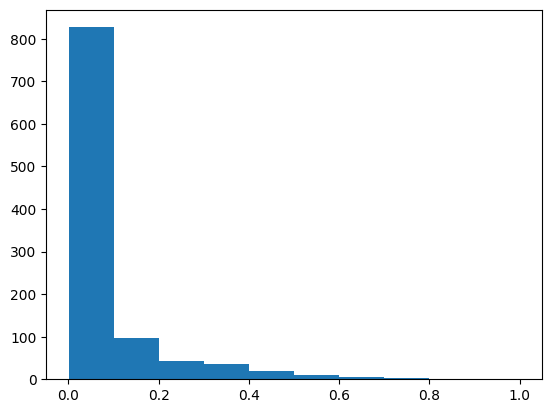

In [62]:
plt.hist(probs['p_connect'])

In [66]:
probs['p_connect'].max()

1.0

## NULL DISTRIBUTION based on FUNCTIONAL DATA

In [191]:
analysis_syn_df.shape

(195304, 15)

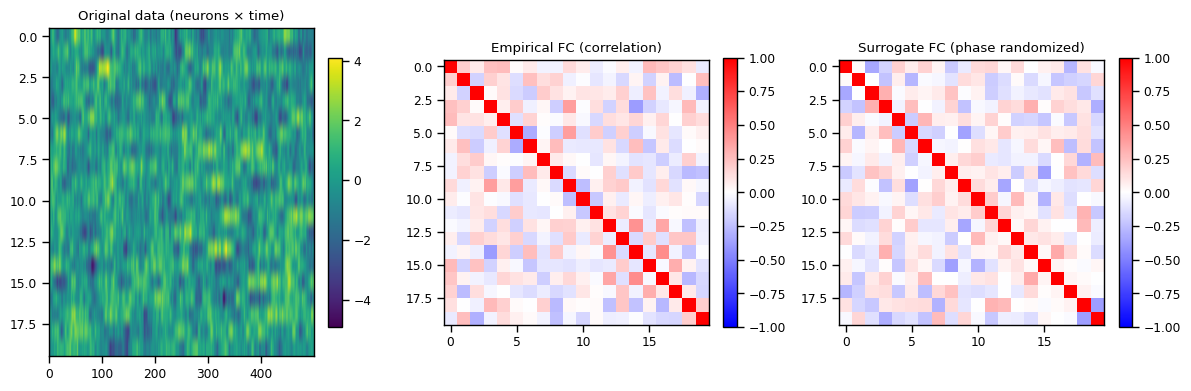

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft


# --- helper: phase randomization for a single time series ---
def phase_randomize(ts, rng):
    """Phase-randomize a 1D time series while preserving power spectrum."""
    T = len(ts)
    X = rfft(ts)
    phases = np.exp(1j * rng.uniform(0, 2 * np.pi, len(X)))
    phases[0] = 1.0  # keep DC component
    if T % 2 == 0:
        phases[-1] = 1.0  # keep Nyquist if present
    Xr = X * phases
    return irfft(Xr, n=T)


# --- synthetic dataset: N neurons x T timepoints ---
rng = np.random.default_rng(0)
N, T = 20, 500
# Each neuron: AR(1) process with slight noise, plus some shared global signal
time = np.arange(T)
global_signal = np.sin(2 * np.pi * time / 50)  # shared oscillation
data = np.zeros((N, T))
for i in range(N):
    noise = rng.normal(scale=0.5, size=T)
    x = np.zeros(T)
    for t in range(1, T):
        x[t] = 0.9 * x[t - 1] + noise[t]  # AR(1)
    data[i] = x + 0.3 * global_signal  # add shared component


# --- compute FC (Pearson correlation) ---
def compute_fc(data):
    data_z = (data - data.mean(axis=1, keepdims=True)) / (
        data.std(axis=1, keepdims=True) + 1e-12)
    return np.corrcoef(data_z)


fc_emp = compute_fc(data)

# --- make one surrogate dataset (phase randomized) ---
surrogate = np.zeros_like(data)
for i in range(N):
    surrogate[i] = phase_randomize(data[i], rng)

fc_surr = compute_fc(surrogate)

# --- plot comparison ---
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(data, aspect='auto', cmap='viridis')
axs[0].set_title("Original data (neurons × time)")
plt.colorbar(im0, ax=axs[0], fraction=0.046)

im1 = axs[1].imshow(fc_emp, vmin=-1, vmax=1, cmap='bwr')
axs[1].set_title("Empirical FC (correlation)")
plt.colorbar(im1, ax=axs[1], fraction=0.046)

im2 = axs[2].imshow(fc_surr, vmin=-1, vmax=1, cmap='bwr')
axs[2].set_title("Surrogate FC (phase randomized)")
plt.colorbar(im2, ax=axs[2], fraction=0.046)

plt.tight_layout()
plt.show()


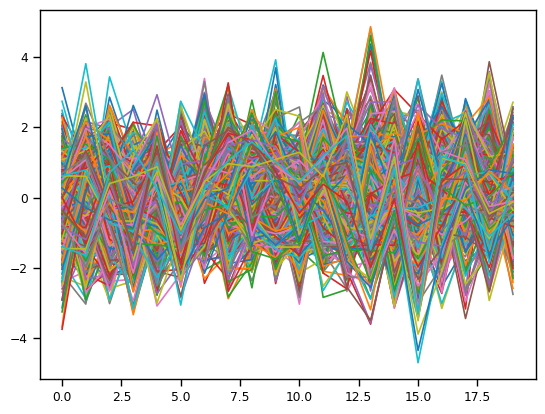

In [51]:
plt.plot(surrogate)
plt.show()

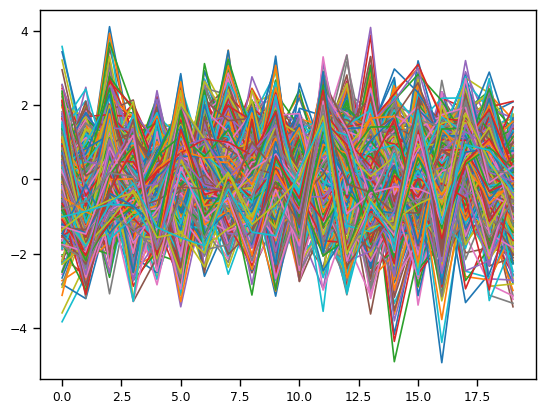

In [52]:
plt.plot(data)
plt.show()

In [40]:
corr_coreg_df = pd.read_feather(
    f"{data_dir}/cell_cell_correlations_by_stimulus_coregistered.feather")

In [41]:
corr_coreg_df

,pre_pt_root_id,post_pt_root_id,drifting_gratings_full,drifting_gratings_windowed,locally_sparse_noise,natural_images,natural_images_12,natural_movie,spontaneous
0,864691132631872354,864691132993747701,0.050142,0.027819,0.154472,0.181724,0.158909,0.004957,0.078471
1,864691132631872354,864691132786447756,0.055267,0.018284,0.119418,0.115587,0.124021,0.010296,0.197349
2,864691132631872354,864691132617961537,0.065444,0.062367,0.143660,0.065078,0.073297,0.053197,0.108968
3,864691132631872354,864691132758875499,0.075457,0.039646,0.057388,0.123202,0.026544,0.025227,0.027960
4,864691132631872354,864691132897987302,0.076981,0.053317,0.107852,0.134347,0.105139,0.022267,0.050300
...,...,...,...,...,...,...,...,...,...
148723,864691132666328483,864691132657942744,0.131218,0.179360,0.207372,0.156714,0.248659,0.144474,0.109482
148724,864691132666328483,864691132725498737,0.107767,0.199380,0.192460,0.226593,0.244469,0.121275,0.300348
148725,864691132666328483,864691132629014588,0.218825,0.182080,0.225877,0.328151,0.107612,0.133220,0.180140
148726,864691132666328483,864691132755147518,0.166679,0.314241,0.192168,0.299734,0.262939,0.130756,0.171932
